<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/ExplNode06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: 멋진 작사가 만들기

# 1 개요

## 1-1. 목표
- LSTM를 이용하여, 입력이 한 단어일 때, 출력으로 문장을 만드는 NN 구현한다.
- 노래 가사 작사 ???????????
- 성능개선을 위한 분석한다.

## 1-2. 방법
- Keras의 LSTM와 과제에서 주어진 coupus와 code를 이용하여 구현한다.
-  1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있습니다.
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환한다.
- tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환한다.
- 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠. 15로 제한
- 성능평가 ?

# 2 데이터 준비 

## 2-1. 기본 라이브러리 load하기

In [22]:
# import warnings
# warnings.filterwarnings("ignore")
# import pandas as pd
import numpy as np
import os, re
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

## 2-2. 기본 code load하기

    maxlen = int(max_tokens)     
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)  

In [103]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) #  4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,               # 7000단어를 기억할 수 있는 tokenizer
        filters=' ',                  # 앞에서 preprocess하므로, 여기서는 불필요
        oov_token="<unk>"             # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿈
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)  
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence를 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated  

## 2-3. corpus 파일 download하기

In [24]:
!rm -r /content/lyrics
!mkdir -p /content/lyrics
!wget -O /content/lyrics.zip https://raw.githubusercontent.com/twelvesense/first-repository/master/data/lyrics/lyrics.zip
!unzip /content/lyrics.zip -d /content/lyrics
!rm /content/lyrics.zip

--2022-05-19 11:32:32--  https://raw.githubusercontent.com/twelvesense/first-repository/master/data/lyrics/lyrics.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2004593 (1.9M) [application/zip]
Saving to: ‘/content/lyrics.zip’

/content/lyrics.zip 100%[===================>]   1.91M  --.-KB/s    in 0.06s   

2022-05-19 11:32:32 (32.9 MB/s) - ‘/content/lyrics.zip’ saved [2004593/2004593]

Archive:  /content/lyrics.zip
  inflating: /content/lyrics/adele.txt  
  inflating: /content/lyrics/al-green.txt  
  inflating: /content/lyrics/alicia-keys.txt  
  inflating: /content/lyrics/amy-winehouse.txt  
  inflating: /content/lyrics/beatles.txt  
  inflating: /content/lyrics/bieber.txt  
  inflating: /content/lyrics/bjork.txt  
  inflating: /content/lyrics/blink-1

In [104]:
txt_file_path = '/content/lyrics/*'
txt_list = glob.glob(txt_file_path)
raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['They say get ready for the revolution', "I think it's time we find some sorta solution", "Somebody's caught up in the endless pollution"]


## 2-4. 데이터 전처리하기

- corpus 전처리

15 개 까지만....

max = 15
for i in range(len(corpus)):
  count = corpus[i][:corpus[i].find('<end>')].count(' ') + 1
  if count > max: numRemoved += 1

In [117]:
len(corpus)

156013

In [118]:
corpus[0:10]

['<start> they say get ready for the revolution <end>',
 '<start> i think it s time we find some sorta solution <end>',
 '<start> somebody s caught up in the endless pollution <end>',
 '<start> why won t somebody feel this <end>',
 '<start> this is my wish that we all feel connected <end>',
 '<start> this is my wish that nobodies neglected be like a rocket baby <end>',
 '<start> be like a rocket take off <end>',
 '<start> just fly , away ay , ay <end>',
 '<start> to find your space take off <end>',
 '<start> just fly , away ay , ay <end>']

In [106]:
MAX_LEN = 15
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue            # 문장길이 0
    if sentence[-1] == ":": continue           # 문장끝 :
    
    preprocessed_sentence = preprocess_sentence(sentence)
    # 15개 까지만...
    if (preprocessed_sentence[:preprocessed_sentence.find('<end>')].count(' ') + 1) > MAX_LEN: 
        print(sentence)
        continue
    corpus.append(preprocessed_sentence)

In [107]:
corpus[0:10]

['<start> they say get ready for the revolution <end>',
 '<start> i think it s time we find some sorta solution <end>',
 '<start> somebody s caught up in the endless pollution <end>',
 '<start> why won t somebody feel this <end>',
 '<start> this is my wish that we all feel connected <end>',
 '<start> this is my wish that nobodies neglected be like a rocket baby <end>',
 '<start> be like a rocket take off <end>',
 '<start> just fly , away ay , ay <end>',
 '<start> to find your space take off <end>',
 '<start> just fly , away ay , ay <end>']

In [116]:
len(corpus)

156013

In [108]:
numRemoved = 0
max = 15
for i in range(len(corpus)):
  count = corpus[i][:corpus[i].find('<end>')].count(' ') + 1
  if count > max: max = count

max

15

In [109]:
numRemoved = 0
max = 15
for i in range(len(corpus)):
  count = corpus[i][:corpus[i].find('<end>')].count(' ') + 1
  if count > max: numRemoved += 1

numRemoved

0

- 텐서만들기

In [110]:
tensor, tokenizer = tokenize(corpus)

[[   2   38   71 ...    0    0    0]
 [   2    4  130 ...    0    0    0]
 [   2  246   17 ...    0    0    0]
 ...
 [   2   20  149 ...    0    0    0]
 [   2    4   35 ...    3    0    0]
 [   2 1061   10 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fd23504e790>


tensor분석하기

- 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [111]:
 tokenizer.num_words

7000

In [112]:
len(tensor[0])

15

In [119]:
tensor[0,:20]

array([   2,   38,   71,   43,  294,   28,    6, 3273,    3,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [120]:
print(tensor[:3, :20])

[[   2   38   71   43  294   28    6 3273    3    0    0    0    0    0
     0]
 [   2    4  130   11   17   76   21  207   94 3521 6826    3    0    0
     0]
 [   2  246   17  622   29   14    6 3069    1    3    0    0    0    0
     0]]


- LSTM에서 many to many의 답을 얻을 것이기 때문에 train은 첫 문장부터 끝에 하나뺀 문장들로 구성을 하고 target은 첫 단어 뺀 문장들로 구성을 합니다,

In [121]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]



In [122]:
print(src_input[0])
print(tgt_input[0])

[   2   38   71   43  294   28    6 3273    3    0    0    0    0    0]
[  38   71   43  294   28    6 3273    3    0    0    0    0    0    0]


## 2-5. validataion용 data 생성하기

- 사이킷 런 패키지를 이용해서 위에서 train과 target을 train과 validation 셋으로 분리를 해줍니다. 8:2로 분리를 하겠습니다.

In [123]:
# train, test 8:2로 나누기
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=22)

- 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있습니다.

# 3 모델 설계

## 3-1. corpus 텐서를 tf.data.Dataset객체로 변환

fdsafdsa

In [127]:
embedding_size = 256
hidden_size = 1024
VOCAB_SIZE = tokenizer.num_words + 1         # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

model = TextGenerator(VOCAB_SIZE, embedding_size , hidden_size)

In [128]:
epochs = 10

# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
model.compile(loss=loss, optimizer=optimizer)

- 문제점: 인력덴서가 무엇인지 미정상태
- model에 데이터를 아주 조금 태워 보는 것도 방법입니다. model의 input shape가 결정되면서 model.build()가 자동으로 호출됩니다.

In [129]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 7001), dtype=float32, numpy=
array([[[-2.67563519e-05, -5.68164687e-05,  4.22008132e-04, ...,
         -5.30208490e-06,  4.35386755e-04,  2.76740146e-04],
        [-2.99895299e-04,  2.61646230e-04,  7.11476721e-04, ...,
         -2.44583527e-04,  9.49296402e-04,  3.94055416e-04],
        [-3.47216584e-04,  6.71739108e-04,  5.72921243e-04, ...,
         -2.69298500e-04,  1.36719621e-03,  2.19789625e-04],
        ...,
        [ 4.92481457e-04, -3.41615261e-04, -2.15352885e-03, ...,
         -1.10786175e-03, -5.96851460e-05, -1.06951094e-03],
        [ 7.42310134e-04, -1.59527583e-04, -2.33880244e-03, ...,
         -1.50653801e-03, -5.10848477e-04, -1.21292495e-03],
        [ 7.97900022e-04,  2.56008789e-04, -2.29813159e-03, ...,
         -1.41283660e-03, -8.55471473e-04, -1.31641084e-03]],

       [[-2.67563519e-05, -5.68164687e-05,  4.22008132e-04, ...,
         -5.30208490e-06,  4.35386755e-04,  2.76740146e-04],
        [-7.91184721e-06,  3.05956608e-04,  7.

In [130]:
steps_per_epoch

609

- 모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 14, 7001)임을 알 수 있습니다. 
- 7001은 Dense 레이어의 출력 차원수입니다. 
- 7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.
- 256은 이전 스텝에서 지정한 배치 사이즈입니다. dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

- 그렇다면 14는 무엇을 의미할까요? 비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 
- 즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

- 그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 모델을 만들면서 알려준 적도 없습니다. 그럼 14는 언제 알게된 것일까요? 
- 네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 14으로 맞춰져 있었던 것입니다.

Model: "text_generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  1792256   
                                                                 
 lstm_2 (LSTM)               multiple                  5246976   
                                                                 
 lstm_3 (LSTM)               multiple                  8392704   
                                                                 
 dense_1 (Dense)             multiple                  7176025   
                                                                 
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


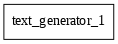

In [134]:
model.summary()
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=True,
    dpi = 70)

- 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

# 4 모델 학습

In [ ]:
history = []

history = model.fit(enc_train, dec_train, 
          epochs=epochs,                         # 10
          batch_size=BATCH_SIZE,                 # 256
          validation_data=(enc_val, dec_val),
          verbose=1)

- 이번처럼 작문 모델을 평가하는 가장 확실한 방법은 작문을 시켜보고 사람이 평가하는 겁니다.
- 아래 generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다.

# 5 모델 평가

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love rubies bloodstains ceased ceased busy busy cab cab pearls pearls had had sp sp steady steady steady '

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

In [ ]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

그래프를 보니 train은 학습하면 할 수록 과적합이 되서 그런지 점점 loss가 줄어드는 모습을 보입니다. 그리고 validation에서의 loss는 train의 학습으로는 한계가 있는지 점점 loss가 줄어드는 폭이 좁아지는 것을 볼 수 있었습니다.

더 좋은 결과를 얻기 위해 어떤 과정이 남아 있을까?

    lstm의 하이퍼 파라미터를 수정 또는 층을 늘린다.
    epochs에 earlystopping을 추가하여 가장 강력할 때 멈춘다.
    각 lstm 층마다 과적합 방지 기법을 사용한다. ( drop out, batchnormalization)
    cross validation을 사용한다.
    optimizer를 Adam말고 시퀀스 데이터에 더 적합하다고 알려진 rmsprop를 사용한다.


# 6 회고

- lstm을 진행하면서 lstm을 3층으로도 쌓고 dence를 2단으로 쌓아 더 강력하게하고 정규화 기법인 drop out이나 batchnormalization 등을 사용하여 단순하게 lstm을 돌렸을 때와 비교를 해보고 싶었지만 코드를 만들어본 결과 하나하나의 epochs가 시간이 너무 오래걸리기도 하고 많은 파라미터를 처리해야 하기 때문에 메모리가 부족할 것 같아서 진행을 못한 점이 아쉽습니다. 
- 어쨋든 간단한 lstm으로 간단한 데이터를 인풋으로 했을 때 적절한 답변을 얻는 모습을 볼 수 있었습니다. 
- 학습시간만 조금 짧았더라면 많은 시도를 했었을 것 같은데 아쉽네요!